# BM25 + SciBERT Hybrid Retrieval (CISI, CSV)

**Authors:**  
Raditya Maheswara, Girindra Daafi Mada, Muhammad Fariz,  
Sultan Rizqinta Sinuraya, Ivan Adito Arba Putra  

**Affiliation:**  
Department of Computer Science and Electronics  
Faculty of Mathematics and Natural Sciences  
Universitas Gadjah Mada, Yogyakarta, Indonesia  

**Course:** Temu Kembali Informasi (Information Retrieval)  
**Supervisor:** Dr. Lukman Heryawan, S.T., M.  

---

This Colab notebook runs **BM25 + SciBERT** hybrid retrieval on the **CISI dataset** using **CSV files**, optimized to keep embeddings on **GPU** and perform similarity on **GPU**.

### Outputs
- **Metrics:** Recall@10, nDCG@10 for BM25, SciBERT, Hybrid  
- **Chart:** Bar chart comparing the metrics  
- **Qualitative Table:** Top-5 titles for a sample query across methods  
- **Exports:** CSVs (summary, per-query metrics, qualitative top-5)  

---

### How to use
1. Upload `cisi_docs.csv`, `cisi_queries.csv`, `cisi_qrels.csv` (schema below)  
2. Enable GPU: *Runtime → Change runtime type → GPU*  
3. Run cells from top to bottom  

### CSV Schemas
- `cisi_docs.csv`: `doc_id,title,text`  
- `cisi_queries.csv`: `query_id,query`  
- `cisi_qrels.csv`: `query_id,doc_id,relevance`  


In [14]:
!pip -q install rank_bm25 transformers torch matplotlib pandas numpy
import warnings; warnings.filterwarnings('ignore')
print('✅ Deps installed. Enable GPU: Runtime > Change runtime type > GPU')

✅ Deps installed. Enable GPU: Runtime > Change runtime type > GPU


In [15]:
from dataclasses import dataclass

@dataclass
class Config:
    top_k: int = 10
    alpha: float = 0.7  # fusion weight: alpha*SciBERT + (1-alpha)*BM25 (after min-max)
    sample_query_idx: int = 0
    scibert_model: str = 'allenai/scibert_scivocab_uncased'
    use_gpu: bool = True

CFG = Config()
CFG

Config(top_k=10, alpha=0.7, sample_query_idx=0, scibert_model='allenai/scibert_scivocab_uncased', use_gpu=True)

In [16]:
from google.colab import files
print('⬆️ Upload cisi_docs.csv, cisi_queries.csv, cisi_qrels.csv')
uploaded = files.upload()
list(uploaded.keys())

⬆️ Upload cisi_docs.csv, cisi_queries.csv, cisi_qrels.csv


Saving cisi_docs.csv to cisi_docs (1).csv
Saving cisi_qrels.csv to cisi_qrels (1).csv
Saving cisi_queries.csv to cisi_queries (1).csv


['cisi_docs (1).csv', 'cisi_qrels (1).csv', 'cisi_queries (1).csv']

In [17]:
import pandas as pd
docs = pd.read_csv('cisi_docs.csv')
queries = pd.read_csv('cisi_queries.csv')
qrels = pd.read_csv('cisi_qrels.csv')

# Basic checks
assert set(['doc_id','title','text']).issubset(docs.columns)
assert set(['query_id','query']).issubset(queries.columns)
assert set(['query_id','doc_id']).issubset(qrels.columns)

# Ensure string IDs
docs['doc_id'] = docs['doc_id'].astype(str)
queries['query_id'] = queries['query_id'].astype(str)
qrels['doc_id'] = qrels['doc_id'].astype(str)
qrels['query_id'] = qrels['query_id'].astype(str)

docs.head(2), queries.head(2), qrels.head(2)

(  doc_id                                             title  \
 0      1  18 Editions of the Dewey Decimal Classifications   
 1      2                   Use Made of Technical Libraries   
 
                                                 text  
 0  The present study is a history of the DEWEY De...  
 1  This report is an analysis of 6300 acts of use...  ,
   query_id                                              query
 0        1  What problems and concerns are there in making...
 1        2  How can actually pertinent data, as opposed to...,
   query_id doc_id  relevance
 0        1     28          1
 1        1     35          1)

In [18]:
import re, numpy as np
from rank_bm25 import BM25Okapi

TOKEN_RE = re.compile(r"[A-Za-z0-9_]+")
def tokenize(t):
    return TOKEN_RE.findall(str(t).lower())

corpus_texts = (docs['title'].fillna('') + '. ' + docs['text'].fillna('')).tolist()
bm25_tokens = [tokenize(t) for t in corpus_texts]
bm25 = BM25Okapi(bm25_tokens)
print('✅ BM25 ready (rank_bm25) | docs:', len(corpus_texts))

✅ BM25 ready (rank_bm25) | docs: 1460


In [20]:
# ==== GPU SciBERT embeddings (keep tensors on GPU) ====
import time, math, gc, subprocess, torch
from transformers import AutoTokenizer, AutoModel
import pandas as pd

try:
    CFG
except NameError:
    from dataclasses import dataclass
    @dataclass
    class Config:
        top_k: int = 10
        alpha: float = 0.7
        sample_query_idx: int = 0
        scibert_model: str = 'allenai/scibert_scivocab_uncased'
        use_gpu: bool = True
    CFG = Config()

USE_GPU = (CFG.use_gpu and torch.cuda.is_available())
DEVICE  = 'cuda' if USE_GPU else 'cpu'
DTYPE   = torch.float16 if (USE_GPU and torch.cuda.get_device_capability(0)[0] >= 7) else torch.float32
BATCH_SIZE = 64
MAX_LEN    = 256

print(f"🔧 Device: {DEVICE} | dtype: {DTYPE} | batch_size: {BATCH_SIZE} | max_len: {MAX_LEN}")
if DEVICE == 'cuda':
    try:
        out = subprocess.run(['nvidia-smi','--query-gpu=memory.total,memory.used,memory.free','--format=csv,noheader,nounits'], capture_output=True, text=True).stdout
        print('📊 GPU mem (total,used,free):\n', out)
    except Exception:
        pass

print('⏳ Loading SciBERT...')
tok = AutoTokenizer.from_pretrained(CFG.scibert_model)
mdl = AutoModel.from_pretrained(
    CFG.scibert_model,
    torch_dtype=DTYPE,
    low_cpu_mem_usage=True
).to(DEVICE).eval()
print('✅ Model loaded')

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    mask = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return (token_embeddings * mask).sum(1) / torch.clamp(mask.sum(1), min=1e-9)

@torch.inference_mode()
def encode(texts, batch_size=BATCH_SIZE, max_length=MAX_LEN, show_every=5):
    def _encode_bs(bs):
        vecs, n = [], len(texts)
        steps = math.ceil(n/bs) if bs>0 else 0
        t_start = time.time()
        for i in range(0, n, bs):
            j = i + bs
            batch = texts[i:j]
            enc = tok(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(DEVICE)
            out = mdl(**enc)
            pooled = mean_pooling(out, enc['attention_mask'])
            pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
            vecs.append(pooled)  # ✅ stay on DEVICE
            k = (i // bs) + 1
            if k % show_every == 0 or j >= n:
                print(f"   • batch {k}/{steps} | {j}/{n} | elapsed {time.time()-t_start:.1f}s")
        return torch.cat(vecs, 0) if len(vecs) else torch.empty((0, mdl.config.hidden_size), device=DEVICE, dtype=DTYPE)

    bs_try = batch_size
    while bs_try >= 8:
        try:
            if DEVICE == 'cuda': torch.cuda.empty_cache()
            return _encode_bs(bs_try)
        except RuntimeError as e:
            if 'out of memory' in str(e).lower():
                print(f'⚠️ OOM at batch_size={bs_try}. Retry with half...')
                bs_try //= 2
                import gc; gc.collect()
                if DEVICE == 'cuda': torch.cuda.empty_cache()
            else:
                raise
    # CPU fallback if really needed
    print('🔁 Fallback to CPU (OOM). This will be slower).')
    cpu_model = mdl.to('cpu').eval()
    vecs, n = [], len(texts)
    for i in range(0, n, 16):
        j = i + 16
        batch = texts[i:j]
        enc = tok(batch, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
        out = cpu_model(**enc)
        pooled = mean_pooling(out, enc['attention_mask'])
        pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
        vecs.append(pooled)
    return torch.cat(vecs, 0)

print('⏳ Encoding corpus with SciBERT (GPU)...')
corpus_vecs = encode(corpus_texts)
print('✅ Embeddings ready:', corpus_vecs.shape, '| device:', corpus_vecs.device, '| dtype:', corpus_vecs.dtype)

🔧 Device: cuda | dtype: torch.float16 | batch_size: 64 | max_len: 256
📊 GPU mem (total,used,free):
 15360, 830, 14264

⏳ Loading SciBERT...
✅ Model loaded
⏳ Encoding corpus with SciBERT (GPU)...
   • batch 5/23 | 320/1460 | elapsed 0.8s
   • batch 10/23 | 640/1460 | elapsed 1.6s
   • batch 15/23 | 960/1460 | elapsed 2.4s
   • batch 20/23 | 1280/1460 | elapsed 3.3s
   • batch 23/23 | 1472/1460 | elapsed 3.8s
✅ Embeddings ready: torch.Size([1460, 768]) | device: cuda:0 | dtype: torch.float32


In [21]:
import numpy as np, torch
def bm25_search(query, k=10):
    q_tokens = tokenize(query)
    scores = bm25.get_scores(q_tokens)
    idx = np.argsort(-scores)[:k]
    return idx, scores[idx]

@torch.inference_mode()
def scibert_search(query, k=10):
    enc = tok([query], padding=True, truncation=True, max_length=256, return_tensors='pt').to(corpus_vecs.device)
    out = mdl(**enc)
    qv = mean_pooling(out, enc['attention_mask'])
    qv = torch.nn.functional.normalize(qv, p=2, dim=1)
    # match dtype/device to corpus_vecs
    if qv.dtype != corpus_vecs.dtype:
        qv = qv.to(dtype=corpus_vecs.dtype)
    if qv.device != corpus_vecs.device:
        qv = qv.to(corpus_vecs.device)
    sims = (qv @ corpus_vecs.T).squeeze(0)
    topk = torch.topk(sims, k=min(k, sims.numel()))
    return topk.indices.detach().cpu().numpy(), topk.values.detach().cpu().numpy()

def minmax(x):
    x = np.asarray(x)
    mn, mx = x.min(), x.max()
    return (x - mn) / (mx - mn + 1e-9) if mx > mn else np.zeros_like(x)

def hybrid_search(query, k=10, alpha=CFG.alpha):
    k_cand = max(100, k)
    b_idx, b_s = bm25_search(query, k=k_cand)
    s_idx, s_s = scibert_search(query, k=k_cand)
    cand = list(dict.fromkeys(list(b_idx) + list(s_idx)))
    b_map = {int(i): float(s) for i, s in zip(b_idx, b_s)}
    s_map = {int(i): float(s) for i, s in zip(s_idx, s_s)}
    # align arrays
    import numpy as _np
    b_full = _np.array([b_map.get(int(cid), 0.0) for cid in cand])
    s_full = _np.array([s_map.get(int(cid), 0.0) for cid in cand])
    b_n, s_n = minmax(b_full), minmax(s_full)
    fuse = alpha * s_n + (1 - alpha) * b_n
    order = _np.argsort(-fuse)[:k]
    return _np.array(cand)[order], fuse[order], b_n[order], s_n[order]

print('✅ Retrieval functions ready (GPU SciBERT)')

✅ Retrieval functions ready (GPU SciBERT)


In [22]:
from collections import defaultdict
import pandas as pd, numpy as np

gold = defaultdict(set)
for _, r in qrels.iterrows():
    gold[str(r['query_id'])].add(str(r['doc_id']))
id_to_docid = docs['doc_id'].tolist()

def recall_at_k(pred_doc_ids, gold_ids):
    if not gold_ids:
        return 0.0
    hits = len(set(pred_doc_ids) & gold_ids)
    return hits / float(len(gold_ids))

def ndcg_at_k(pred_doc_ids, gold_ids, k=10):
    gains = []
    for i, did in enumerate(pred_doc_ids[:k], start=1):
        gains.append(1.0 / np.log2(i + 1) if did in gold_ids else 0.0)
    dcg = float(np.sum(gains))
    ideal_hits = min(k, len(gold_ids))
    ideal = np.sum([1.0 / np.log2(i + 1) for i in range(1, ideal_hits + 1)]) if ideal_hits > 0 else 0.0
    return dcg / ideal if ideal > 0 else 0.0

rows = []
for _, q in queries.iterrows():
    qid = str(q['query_id'])
    qtext = q['query']
    b_idx, _ = bm25_search(qtext, k=CFG.top_k)
    b_docs = [str(id_to_docid[j]) for j in b_idx]
    s_idx, _ = scibert_search(qtext, k=CFG.top_k)
    s_docs = [str(id_to_docid[j]) for j in s_idx]
    h_idx, _, _, _ = hybrid_search(qtext, k=CFG.top_k, alpha=CFG.alpha)
    h_docs = [str(id_to_docid[j]) for j in h_idx]
    gset = gold.get(qid, set())
    rows.append({
        'query_id': qid,
        'bm25_recall@10': recall_at_k(b_docs, gset),
        'bm25_ndcg@10': ndcg_at_k(b_docs, gset, k=CFG.top_k),
        'scibert_recall@10': recall_at_k(s_docs, gset),
        'scibert_ndcg@10': ndcg_at_k(s_docs, gset, k=CFG.top_k),
        'hybrid_recall@10': recall_at_k(h_docs, gset),
        'hybrid_ndcg@10': ndcg_at_k(h_docs, gset, k=CFG.top_k)
    })

per_query = pd.DataFrame(rows)
summary = pd.DataFrame({
    'Model': ['BM25','SciBERT','Hybrid'],
    'Recall@10': [per_query['bm25_recall@10'].mean(), per_query['scibert_recall@10'].mean(), per_query['hybrid_recall@10'].mean()],
    'nDCG@10': [per_query['bm25_ndcg@10'].mean(), per_query['scibert_ndcg@10'].mean(), per_query['hybrid_ndcg@10'].mean()],
})
summary

,Model,Recall@10,nDCG@10
0,BM25,0.053388,0.164382
1,SciBERT,0.017913,0.073651
2,Hybrid,0.037926,0.129650


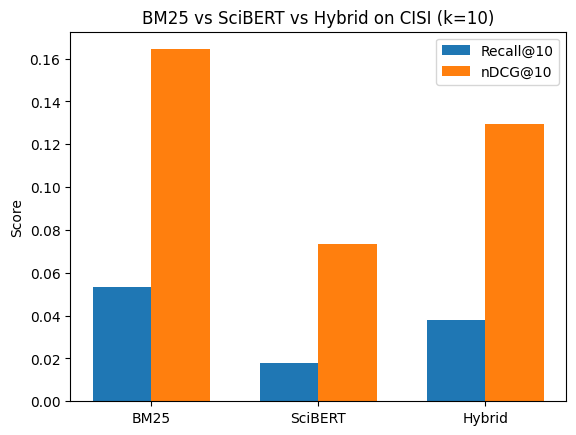

,Model,Recall@10,nDCG@10
0,BM25,0.053388,0.164382
1,SciBERT,0.017913,0.073651
2,Hybrid,0.037926,0.129650


In [23]:
import matplotlib.pyplot as plt, numpy as np
x = np.arange(len(summary['Model']))
width = 0.35
plt.figure()
plt.bar(x - width/2, summary['Recall@10'], width, label='Recall@10')
plt.bar(x + width/2, summary['nDCG@10'], width, label='nDCG@10')
plt.xticks(x, summary['Model'])
plt.ylabel('Score')
plt.title('BM25 vs SciBERT vs Hybrid on CISI (k=10)')
plt.legend(); plt.show()
summary

In [25]:
import pandas as pd
qid = queries.iloc[CFG.sample_query_idx]['query_id']
qtext = queries.iloc[CFG.sample_query_idx]['query']
print('Sample Query ID:', qid)
print('Query:', qtext)
b_idx, _ = bm25_search(qtext, k=5)
s_idx, _ = scibert_search(qtext, k=5)
h_idx, _, _, _ = hybrid_search(qtext, k=5, alpha=CFG.alpha)
def titles(idxs):
    return [docs.iloc[i]['title'] for i in idxs]
table = pd.DataFrame({'Rank':[1,2,3,4,5], 'BM25':titles(b_idx), 'SciBERT':titles(s_idx), 'Hybrid':titles(h_idx)})
table

Sample Query ID: 1
Query: What problems and concerns are there in making up descriptive titles? What difficulties are involved in automatically retrieving articles from approximate titles? What is the usual relevance of the content of articles to their titles?


,Rank,BM25,SciBERT,Hybrid
0,1,Adventures in Librarianship,Issues in Semantics,The Information Content of Titles in Engineeri...
1,2,The Information Content of Titles in Engineeri...,The Application of Pattern Recognition to Scre...,A Study of Searching the Eye Research Literature
2,3,Library Education and the Public Library,The Information Content of Titles in Engineeri...,Are Titles of Chemical Papers Becoming More In...
3,4,Information Transfer Limitations of Titles of ...,Compound Words: A Problem in Post-Coordinate R...,Some Aspects of Developing and Studying a Desc...
4,5,A Note on the Pseudo-Mathematics of Relevance,The Hidden Dimension,The Civic Culture


In [27]:
summary.to_csv('/content/cisi_summary_metrics.csv', index=False)
per_query.to_csv('/content/cisi_per_query_metrics.csv', index=False)
table.to_csv('/content/cisi_qualitative_top5.csv', index=False)
print('Saved to /content: cisi_summary_metrics.csv, cisi_per_query_metrics.csv, cisi_qualitative_top5.csv')

Saved to /content: cisi_summary_metrics.csv, cisi_per_query_metrics.csv, cisi_qualitative_top5.csv
